In [38]:
import sys
sys.path.append('deps/sparse_rrt')
sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from tools.pcd_generation import rectangle_pcd

obs_list = []
width = 8.
near = width * 2
car_width = 16.0
car_len = 8.0
print('generating obs...')
for i in range(1):
    obs_single = []
    for j in range(5):
        low_x = -25 + width/2
        high_x = 25 - width/2
        low_y = -35 + width/2
        high_y = 35 - width/2
        while True:
            # randomly sample in the entire space
            obs = np.random.uniform(low=[low_x, low_y], high=[high_x, high_y])
            # check if it is near enough to previous obstacles
            too_near = False
            for k in range(len(obs_single)):
                if np.linalg.norm(obs - obs_single[k]) < near:
                    too_near = True
                    break
            if not too_near:
                break
            
        obs_single.append(obs)
    obs_single = np.array(obs_single)
    obs_list.append(obs_single)
obs_list = np.array(obs_list)
# convert from obs to point cloud
obc_list = rectangle_pcd(obs_list, width, 1400)
print('generated.')
print(obs_list.shape)

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list[0]

obs_list_to_corner = []
for i in range(len(obs_list)):
    obs_list_to_corner_i = []
    obs_list_to_corner_i.append(obs_list[i][0]-width/2)
    obs_list_to_corner_i.append(obs_list[i][1]-width/2)
    obs_list_to_corner_i.append(obs_list[i][0]+width/2)
    obs_list_to_corner_i.append(obs_list[i][1]-width/2)
    obs_list_to_corner_i.append(obs_list[i][0]+width/2)
    obs_list_to_corner_i.append(obs_list[i][1]+width/2)
    obs_list_to_corner_i.append(obs_list[i][0]-width/2)
    obs_list_to_corner_i.append(obs_list[i][1]+width/2)
    obs_list_to_corner.append(obs_list_to_corner_i)
obs_list_to_corner = np.array(obs_list_to_corner)

generating obs...
generated.
(1, 5, 2)


In [184]:

def overlap(b1corner,b1axis,b1orign,b1dx,b1dy,b2corner,b2axis,b2orign,b2dx,b2dy):
    # this only checks overlap of b1 w.r.t. b2
    # a complete check should do in both directions
    b2ds = [b2dx, b2dy]
    for a in range(0,2):
        t=b1corner[0][0]*b2axis[a][0]+b1corner[0][1]*b2axis[a][1] # project corner to the axis by inner product

        tMin = t
        tMax = t
        for c in range(1,4):
            t = b1corner[c][0]*b2axis[a][0]+b1corner[c][1]*b2axis[a][1] # project corner to the axis by inner product
            # find range by [tMin, tMax]
            if t < tMin:
                tMin = t
            elif t > tMax:
                tMax = t
        # since b2 the other corners (corner 1, 2, 3) are larger than b2orign (project of corner 0 to axis)
        # specifically, the range is [b2orign[i], b2orign[i]+size(i)] (of the projected point by dot product)
        # we only need to compare tMax with b2orign[i], and tMin with size(i)+b2orign[i]
        if ((tMin > (b2ds[a] + b2orign[a])) or (tMax < b2orign[a])):
            return False

    return True


def enforce_bounds(state):
    '''

    check if state satisfies the bound
    apply threshold to velocity and angle
    return a new state toward which the bound has been enforced
    '''
    WIDTH = 1.0
    LENGTH = 2.0

    STATE_X = 0
    STATE_Y = 1

    STATE_THETA = 2 
    MIN_X = -25
    AX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    
    
    new_state = np.array(state)
    """
    if state[STATE_V] < MIN_V/30.:
        new_state[STATE_V] = MIN_V/30.
    elif state[STATE_V] > MAX_V/30.:
        new_state[STATE_V] = MAX_V/30.
    """
    if state[2] < -np.pi:
        new_state[2] += 2*np.pi
    elif state[2] > np.pi:
        new_state[2] -= 2*np.pi
    return new_state

def IsInCollision(x, obc, obc_width=4.):

    
    WIDTH = car_width # 1.0
    LENGTH = car_len # 2.0
    STATE_X = 0
    STATE_Y = 1
    STATE_THETA = 2
    MIN_X = -25
    MAX_X = 25
    MIN_Y = -35
    MAX_Y = 35
    if x[0] < MIN_X or x[0] > MAX_X or x[1] < MIN_Y or x[1] > MAX_Y:
        return True
        
    robot_corner=np.zeros((4,2),dtype=np.float32)
    robot_axis=np.zeros((2,2),dtype=np.float32)
    robot_orign=np.zeros(2,dtype=np.float32)
    length=np.zeros(2,dtype=np.float32)
    X1=np.zeros(2,dtype=np.float32)
    Y1=np.zeros(2,dtype=np.float32)

    X1[0]=np.cos(x[STATE_THETA])*(WIDTH/2.0)
    X1[1]=-np.sin(x[STATE_THETA])*(WIDTH/2.0)
    Y1[0]=np.sin(x[STATE_THETA])*(LENGTH/2.0)
    Y1[1]=np.cos(x[STATE_THETA])*(LENGTH/2.0)

    for j in range(0,2):
        # order: (left-bottom, right-bottom, right-upper, left-upper)
        robot_corner[0][j]=x[j]-X1[j]-Y1[j]
        robot_corner[1][j]=x[j]+X1[j]-Y1[j]
        robot_corner[2][j]=x[j]+X1[j]+Y1[j]
        robot_corner[3][j]=x[j]-X1[j]+Y1[j]

        # axis: horizontal and vertical
        robot_axis[0][j] = robot_corner[1][j] - robot_corner[0][j]
        robot_axis[1][j] = robot_corner[3][j] - robot_corner[0][j]

    print('robot corners:')
    print(robot_corner)
    length[0]=np.sqrt(robot_axis[0][0]*robot_axis[0][0]+robot_axis[0][1]*robot_axis[0][1])
    length[1]=np.sqrt(robot_axis[1][0]*robot_axis[1][0]+robot_axis[1][1]*robot_axis[1][1])
    # normalize the axis
    for i in range(0,2):
        for j in range(0,2):
            robot_axis[i][j]=robot_axis[i][j]/float(length[i])

    # obtain the projection of the left-bottom corner to the axis, to obtain the minimal projection length
    robot_orign[0]=robot_corner[0][0]*robot_axis[0][0]+ robot_corner[0][1]*robot_axis[0][1]
    robot_orign[1]=robot_corner[0][0]*robot_axis[1][0]+ robot_corner[0][1]*robot_axis[1][1]
    print('robot orign:')
    print(robot_orign)
    for i in range(len(obc)):
        cf=True

        obs_corner=np.zeros((4,2),dtype=np.float32)
        obs_axis=np.zeros((2,2),dtype=np.float32)
        obs_orign=np.zeros(2,dtype=np.float32)
        length2=np.zeros(2,dtype=np.float32)

        for j in range(0,2):
            # order: (left-bottom, right-bottom, right-upper, left-upper)
            obs_corner[0][j] = obc[i][j]
            obs_corner[1][j] = obc[i][2+j]
            obs_corner[2][j] = obc[i][2*2+j]
            obs_corner[3][j] = obc[i][3*2+j]
            
            # horizontal axis and vertical
            obs_axis[0][j] = obs_corner[1][j] - obs_corner[0][j]
            obs_axis[1][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[0][j] = obs_corner[3][j] - obs_corner[0][j]
            #obs_axis[1][j] = obs_corner[1][j] - obs_corner[0][j]

        length2[0]=np.sqrt(obs_axis[0][0]*obs_axis[0][0]+obs_axis[0][1]*obs_axis[0][1])
        length2[1]=np.sqrt(obs_axis[1][0]*obs_axis[1][0]+obs_axis[1][1]*obs_axis[1][1])

        # normalize the axis
        for i1 in range(0,2):
            for j1 in range(0,2):
                obs_axis[i1][j1]=obs_axis[i1][j1]/float(length2[i1])

        # obtain the inner product of the left-bottom corner with the axis to obtain the minimal of projection value
        obs_orign[0]=obs_corner[0][0]*obs_axis[0][0]+ obs_corner[0][1]*obs_axis[0][1]  # dot product at 0-th corner
        obs_orign[1]=obs_corner[0][0]*obs_axis[1][0]+ obs_corner[0][1]*obs_axis[1][1]
        # do checking in both direction (b1 -> b2, b2 -> b1). If at least one shows not-overlapping, then it is not overlapping
        cf=overlap(robot_corner,robot_axis,robot_orign,car_width,car_len,obs_corner,obs_axis,obs_orign,width,width)
        cf=cf and overlap(obs_corner,obs_axis,obs_orign,width,width,robot_corner,robot_axis,robot_orign,car_width,car_len)
        if cf==True:
            return True
    return False



In [181]:
# visualize the path
"""
Given a list of states, render the environment
"""
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from IPython.display import HTML
from visual.visualizer import Visualizer
from mpl_toolkits.mplot3d import Axes3D



class CarVisualizer(Visualizer):
    def __init__(self, system, params):
        super(CarVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig = plt.gcf()
        self.fig.set_figheight(5)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(121)
        #self.ax2 = plt.subplot(122)
        self.ax2 = self.fig.add_subplot(122, projection='3d')

        
    def _init(self):
        # clear the current ax
        ax = self.ax1
        ax.clear()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-35, 35)
        # add patches
        state = self.states[0]
        self.car = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor='blue',facecolor='blue')
        self.car_direction = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                           linewidth=1.0, edgecolor='black')
        self.recs = []
        self.recs.append(self.car)
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor='black',facecolor='black')
            self.recs.append(obs)
            ax.add_patch(obs)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car.set_transform(t)
        ax.add_patch(self.car)
        self.car_direction.set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)

        # add goal patch
        state = self.states[-1]
        self.car_goal = patches.Rectangle((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2),\
                                       self.params['car_w'],self.params['car_l'],\
                                      linewidth=.5,edgecolor='red',facecolor='red')
        self.recs.append(self.car_goal)
        # transform pole according to state
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.car_goal.set_transform(t)
        ax.add_patch(self.car_goal)

        #self.cc_obs = np.array(self.cc_obs)
        #ax.scatter(self.cc_obs[:,[0, 2, 4, 6]], self.cc_obs[:,[1, 3, 5, 7]], color='yellow')
        
        
        # state
        state = self.states[0]
        ax = self.ax2
        ax.clear()
        ax.set_xlim3d(-25, 25)
        ax.set_ylim3d(-35,35)
        ax.set_zlim3d(-np.pi,np.pi)

        
        dx = 1
        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*25./dx)
        jmin = 0
        jmax = int(2*35./dx)
        zmin = 0
        zmax = int(2*np.pi/dtheta)
        
        """
        for i in range(imin, imax):
            for j in range(jmin, jmax):
                for z in range(zmin, zmax):
                    x = np.array([dx*i-25, dx*j-35, 0., 0., dtheta*z-np.pi, 0., 0., 0.])
                    if IsInCollision(x, self.cc_obs):
                        infeasible_points.append(x)
                    else:
                        feasible_points.append(x)
        
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)
        #ax.scatter(feasible_points[:,0], feasible_points[:,2], c='yellow')
        ax.scatter(infeasible_points[:,0], infeasible_points[:,1], infeasible_points[:,4], c='black')
        """
        
        scat_state = ax.scatter([state[0]], [state[1]], [state[2]], c='blue')
        self.recs.append(scat_state)
        
        state = self.states[-1]
        
        ax.scatter([state[0]], [state[1]], [state[2]], c='red', marker='*')

        
        # draw the goal region
        #ax = self.ax1
        # randomly sample several points
        
        
        
        return self.recs
    def _animate(self, i):
        ax = plt.gca()
        ax.set_xlim(-25, 25)
        ax.set_ylim(-35, 35)
        state = self.states[i]
        self.recs[0].set_xy((state[0]-self.params['car_w']/2,state[1]-self.params['car_l']/2))
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[0].set_transform(t)
        # modify car_direction
        self.car_direction_patch.remove()
        self.car_direction = patches.Arrow(state[0],state[1],\
                                           self.params['car_w']/2,0,\
                                      linewidth=1.0, edgecolor='black')
        self.recs[1] = self.car_direction
        t = mpl.transforms.Affine2D().rotate_deg_around(state[0], state[1], \
                                                        -state[2]/np.pi * 180) + ax.transData
        self.recs[1].set_transform(t)
        self.car_direction_patch = ax.add_patch(self.car_direction)

        # print location of cart
        self.recs[-1].set_offsets([state[0], state[1], state[2]])

        return self.recs


    def animate(self, states, actions, costs, obstacles, mode='plot'):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = width
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        self.states = states
        self.obs = obstacles

        if mode == 'animate':    
            for i in range(len(states)-1):
                print('state: %d, remaining: %d' % (i, len(states)-i))
                action = actions[i]
                # number of steps for propagtion
                #num_steps = int(np.round(costs[i]/self.params['integration_step']))
                num_steps =100000
                for j in range(num_steps):
                    traj.append(np.array(s))
                    #print("porpagating...")
                    #print(s)
                    #print('st:')
                    #print(sT)
                    s = self.system(s, action, self.params['integration_step'])
                    assert not IsInCollision(s, obs_i)
                    if np.linalg.norm(s - states[i+1]) <= 1e-3:
                        break

            traj = np.array(traj)
            print("animating...")
            # animate
            self.states = traj
            print(traj)
            self.obs = obstacles
            print(len(self.states))
            self.total = len(self.states)

            ani = animation.FuncAnimation(plt.gcf(), self._animate, range(0, len(self.states)),
                                          interval=self.dt, blit=True, init_func=self._init,
                                          repeat=True)
            return ani
        else:
            self._init()
            plt.show()
            return

start:
[-7.88510301 13.27546067  2.65989592]
robot corners:
[[ -2.648556   20.52657  ]
 [-16.827919   13.114033 ]
 [-13.12165     6.024352 ]
 [  1.0577122  13.436888 ]]
robot orign:
[ -7.162444 -19.417887]
isincollision:  False


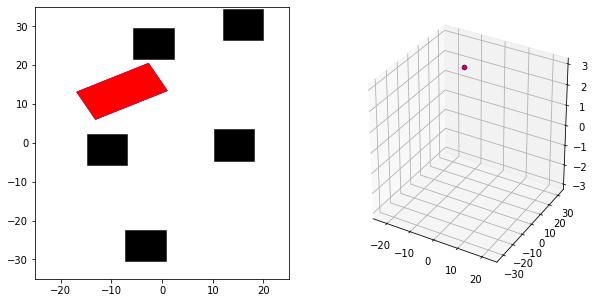

In [311]:
low = []
high = []
system = standard_cpp_systems.RectangleObs(obs_list, width, 'car')

state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
    
start = np.random.uniform(low=low, high=high)

print('start:')
print(start)
print('isincollision: ', IsInCollision(start, obs_list_to_corner, width))


params = {}
params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.002

propagate_system = _sst_module.RallyCar()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(propagate_system, x, u, t)

vis = CarVisualizer(dynamics, params)
vis.animate([start, start], [], [], obs_list)



In [175]:
print('isincollision: ', IsInCollision(start, obs_list_to_corner, width))


robot corners:
[[-12.565275  -17.384312 ]
 [ -2.3676317 -29.713467 ]
 [  3.7969458 -24.614645 ]
 [ -6.400697  -12.285491 ]]
robot orign:
[ 18.783224 -15.921164]
obs_corner
[[-14.874339   -5.7053375]
 [ -6.8743396  -5.7053375]
 [ -6.8743396   2.2946625]
 [-14.874339    2.2946625]]
obstacle orign:
[-14.874339   -5.7053375]
obs_corner
[[12.00148 26.55624]
 [20.00148 26.55624]
 [20.00148 34.55624]
 [12.00148 34.55624]]
obstacle orign:
[12.00148 26.55624]
obs_corner
[[-5.679159  21.654938 ]
 [ 2.3208406 21.654938 ]
 [ 2.3208406 29.654938 ]
 [-5.679159  29.654938 ]]
obstacle orign:
[-5.679159 21.654938]
obs_corner
[[10.201116  -4.5476875]
 [18.201115  -4.5476875]
 [18.201115   3.4523127]
 [10.201116   3.4523127]]
obstacle orign:
[10.201116  -4.5476875]
obs_corner
[[ -7.2552505 -30.458754 ]
 [  0.7447497 -30.458754 ]
 [  0.7447497 -22.458754 ]
 [ -7.2552505 -22.458754 ]]
obstacle orign:
[ -7.2552505 -30.458754 ]
isincollision:  True


In [5]:
print('here')
#obs_list = np.array(obs_list)
system = standard_cpp_systems.RectangleObs(obs_list, width, 'car')
#system = CartPoleObs(obs_list)
# Create SST planner
min_time_steps = 10
max_time_steps = 200
integration_step = 0.002
max_iter = 300000
goal_radius=.5
random_seed=0
sst_delta_near=.6
sst_delta_drain=.2

low = []
high = []
state_bounds = system.get_state_bounds()
for i in range(len(state_bounds)):
    low.append(state_bounds[i][0])
    high.append(state_bounds[i][1])
    

# make sure start and goal are collision-free
while True:
    start = np.random.uniform(low=low, high=high)
    end = np.random.uniform(low=low, high=high)
    print('start:')
    print(start)
    print('end:')
    print(end)
    if not IsInCollision(start, obs_list_to_corner, width) and not IsInCollision(end, obs_list_to_corner, width):
        break
    #break

here
start:
[-23.18374994  20.3013484    1.01407324]
end:
[-15.74387414 -22.38961834   1.36926582]
start:
[10.21926641 -7.07042932 -0.73378125]
end:
[-10.02447197  28.9337733    2.92132825]
start:
[-20.01672449  30.54711821  -1.79929003]
end:
[-13.32658071  13.50535031  -1.40536629]
start:
[-16.57407621 -30.13021912   2.81836317]
end:
[-24.54739322   7.81463397  -0.93131549]
start:
[19.72898799 26.32512543  2.98964926]
end:
[ 9.81544449 -7.77173849  0.75211574]
start:
[22.30762296 14.682972    1.55683502]
end:
[21.67923694  8.56391385  1.32913996]
start:
[3.05520599 5.13200098 1.24215971]
end:
[ -3.06498194 -27.85333732  -0.40627581]
start:
[-13.24692278  22.72229894  -2.12161589]
end:
[ 20.57752661 -27.72964678  -0.65881617]
start:
[ 9.24228607 26.34016533  0.89018789]
end:
[-8.27686229 34.75953919 -0.34800412]
start:
[-6.1767754  20.78191558 -2.11606863]
end:
[-21.39014205   4.3081186   -0.07773923]
start:
[7.89783362 6.84956921 0.91945488]
end:
[ 16.7316225  -23.30434628  -2.3640775

start:
[-20.78577743 -26.44660033  -0.94299551]
end:
[20.54725567 17.76310908 -1.26034108]


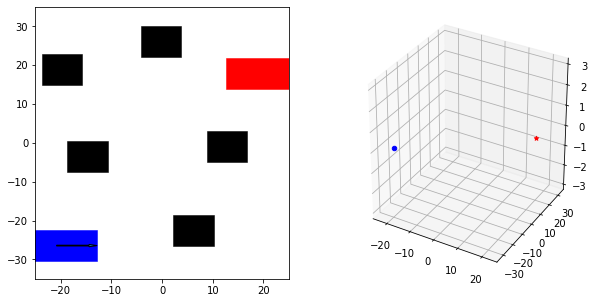

In [6]:
print('start:')
print(start)
print('end:')
print(end)
start[2] = 0
end[2] = 0

params = {}
params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = integration_step

propagate_system = _sst_module.Car()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(propagate_system, x, u, t)

vis = CarVisualizer(dynamics, params)
#states, actions, costs = solution
#states, actions, costs, obstacles
vis.animate([start, end], [], [], obs_list)

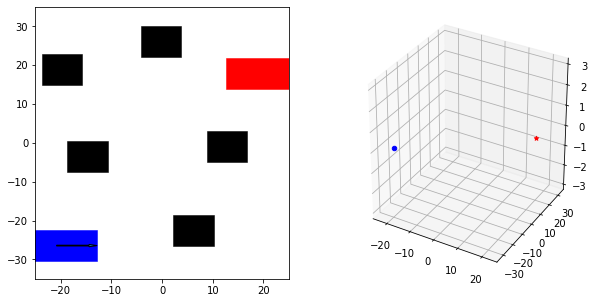

iteration: 0/300000


KeyboardInterrupt: 

In [7]:


#start[2] = 0.
#start[3] = 0.

#end[1] = 0.
#end[3] = 0.
planner = SST(
    state_bounds=system.get_state_bounds(),
    control_bounds=system.get_control_bounds(),
    distance=system.distance_computer(),
    start_state=start,
    goal_state=end,
    goal_radius=goal_radius,
    random_seed=0,
    sst_delta_near=sst_delta_near,
    sst_delta_drain=sst_delta_drain
)


params = {}
params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.02

propagate_system = _sst_module.Car()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(propagate_system, x, u, t)

vis = CarVisualizer(dynamics, params)
#states, actions, costs = solution
#states, actions, costs, obstacles
vis.animate([start, end], [], [], obs_list)
#HTML(anim.to_html5_video())



# Run planning and print out solution is some statistics every few iterations.

time0 = time.time()
ax = vis.ax2

for iteration in range(max_iter):
    #if iteration % 50 == 0:
    #    # from time to time use the goal
    #    sample = end
    #    planner.step_with_sample(system, sample, 20, 200, 0.002)
    #else:
    if iteration % int(0.1 * max_iter) == 0:        
        print('iteration: %d/%d' % (iteration, max_iter))
    steer_start, steer_end = planner.step_with_output(system, min_time_steps, max_time_steps, integration_step)
    #print('start:')
    #print(steer_start)
    #print('end:')
    #print(steer_end)
    #ax.scatter(steer_start[0], steer_start[1], steer_start[4], c='red')
    #ax.scatter(steer_end[0], steer_end[1], steer_end[4], c='blue')

    #    #sample = np.random.uniform(low=low, high=high)
    #print('iteration: %d' % (iteration))
    # interation: 0.002
    #planner.step_with_sample(system, sample, 2, 20, 0.01)
    
    #if iteration % 100 == 0:
solution = planner.get_solution()
print("Solution: %s, Number of nodes: %s" % (planner.get_solution(), planner.get_number_of_nodes()))

print('time spent: %f' % (time.time() - time0))
assert solution is not None


In [ ]:
states, actions, costs = solution
print(states.shape)
print(actions.shape)

In [ ]:
params = {}
params['car_w'] = car_width
params['car_l'] = car_len
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = integration_step

propagate_system = _sst_module.Car()
cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(propagate_system, x, u, t)

vis = CarVisualizer(dynamics, params)
states, actions, costs = solution
anim = vis.animate(np.array(states), np.array(actions), np.array(costs), obs_list, mode='animate')
HTML(anim.to_html5_video())


In [ ]:
print(obs_list)